In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [ ]:
class ROIDataset(Dataset):
    def __init__(self, signal_noise_path, roi_path, indices):
        self.signal_noise = np.memmap(signal_noise_path, dtype=np.float32, mode='r', shape=(1000, 1280, 2128))
        self.roi = np.load(roi_path, mmap_mode='r')  # mmap for efficiency
        self.indices = indices  # Define which samples to use

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        x = torch.tensor(self.signal_noise[index], dtype=torch.float32).unsqueeze(0)  # Add channel dim
        y = torch.tensor(self.roi[index], dtype=torch.float32).unsqueeze(0)
        return x, y

# Create dataset splits
train_indices = list(range(0, 700))
val_indices = list(range(700, 850))
test_indices = list(range(850, 1000))

train_dataset = ROIDataset("noise.raw", "roi.npy", train_indices)
val_dataset = ROIDataset("noise.raw", "roi.npy", val_indices)
test_dataset = ROIDataset("noise.raw", "roi.npy", test_indices)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
class ROIFinder(nn.Module):
    def __init__(self):
        super(ROIFinder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.sigmoid(self.conv3(x))  # Binary classification (signal present or not)
        return x

model = ROIFinder().cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import matplotlib.pyplot as plt

def train_roi_finder(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = evaluate(model, val_loader, criterion)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Plot Training vs Validation Loss
    plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs+1), val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss Over Epochs")
    plt.show()

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(loader)

# Run training
train_roi_finder(model, train_loader, val_loader, criterion, optimizer, epochs=10)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder().cuda()
ae_criterion = nn.MSELoss()
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [ ]:
def train_autoencoder(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, _ in train_loader:  # Only need input (no target)
            inputs = inputs.cuda()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  # Try to reconstruct the input
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        val_loss = evaluate(model, val_loader, criterion)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader)}, Val Loss: {val_loss}")

train_autoencoder(autoencoder, train_loader, val_loader, ae_criterion, ae_optimizer, epochs=10)

In [ ]:
import matplotlib.pyplot as plt

def visualize_reconstruction(model, test_loader):
    model.eval()
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.cuda()
            outputs = model(inputs)
            break  # Take the first batch

    inputs = inputs.cpu().numpy()[0, 0]  # Convert back to NumPy
    outputs = outputs.cpu().numpy()[0, 0]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Noisy Input")
    plt.imshow(inputs, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Signal")
    plt.imshow(outputs, cmap='gray')

    plt.show()

visualize_reconstruction(autoencoder, test_loader)

In [ ]:
## Below we train on TPC 0 Col Plane data only ##

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import os

In [2]:
# Load memmap files
signal_memmap = np.memmap("signal.raw", dtype=np.float32, mode='r', shape=(1000, 1280, 2128))
noise_memmap = np.memmap("noise.raw", dtype=np.float32, mode='r', shape=(1000, 1280, 2128))
roi_memmap = np.load("roi.npy")  # ROI is loaded directly

# Extract only TPC 0 Plane Z (channels 800-1039)
signal_data = signal_memmap[:, 800:1040, :]
noise_data = noise_memmap[:, 800:1040, :]
roi_data = roi_memmap[:, 800:1040, :]

# Normalize input (optional, based on data distribution)
signal_data = (signal_data - np.mean(signal_data)) / np.std(signal_data)
noise_data = (noise_data - np.mean(noise_data)) / np.std(noise_data)

# Reshape data to treat each channel separately
num_events, num_channels, num_timesteps = signal_data.shape
X = noise_data.reshape(num_events * num_channels, 1, num_timesteps)  # (num_samples, 1, 2128)
Y = roi_data.reshape(num_events * num_channels, 1, num_timesteps)    # (num_samples, 1, 2128)

In [3]:
class ROIDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Define dataset
dataset = ROIDataset(X, Y)

# Train-validation-test split
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
class ROIFinder(nn.Module):
    def __init__(self):
        super(ROIFinder, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.fc = nn.Linear(64 * 2128, 2128)  # Fully connected layer to match output size

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        x = torch.sigmoid(x)  # Output probabilities between 0 and 1
        return x

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ROIFinder().to(device)

Starting training from scratch...
Epoch 1/10, Train Loss: 0.6932, Val Loss: 0.6931
Checkpoint saved at epoch 1
Epoch 2/10, Train Loss: 0.6931, Val Loss: 0.6931
Checkpoint saved at epoch 2
Epoch 3/10, Train Loss: 0.6931, Val Loss: 0.6931
Checkpoint saved at epoch 3
Epoch 4/10, Train Loss: 0.6931, Val Loss: 0.6931
Checkpoint saved at epoch 4
Epoch 5/10, Train Loss: 0.6931, Val Loss: 0.6931
Checkpoint saved at epoch 5
Epoch 6/10, Train Loss: 0.6931, Val Loss: 0.6931
Checkpoint saved at epoch 6
Epoch 7/10, Train Loss: 0.6931, Val Loss: 0.6931
Checkpoint saved at epoch 7
Epoch 8/10, Train Loss: 0.6931, Val Loss: 0.6931
Checkpoint saved at epoch 8
Epoch 9/10, Train Loss: 0.6931, Val Loss: 0.6931
Checkpoint saved at epoch 9
Epoch 10/10, Train Loss: 0.6931, Val Loss: 0.6931
Checkpoint saved at epoch 10


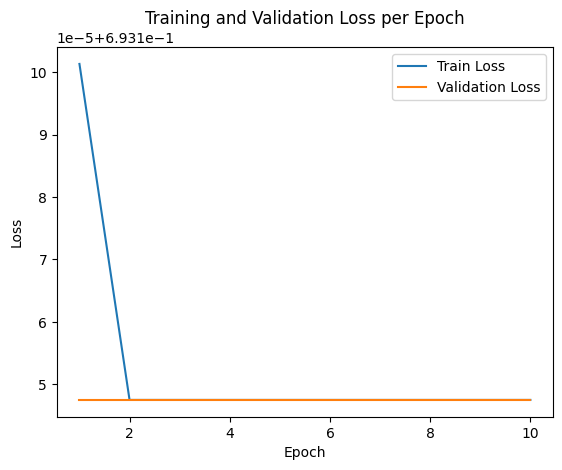

In [5]:
import matplotlib.pyplot as plt

# Define Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Tracking loss values
train_losses = []
val_losses = []

# Path to save the checkpoint
checkpoint_path = "roi_finder_checkpoint.pth"

# Check if a checkpoint exists and load it
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Resuming training from epoch {start_epoch}...")
else:
    start_epoch = 0
    print("Starting training from scratch...")

# Training loop
num_epochs = 10
for epoch in range(start_epoch, num_epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)

        loss = criterion(outputs, batch_Y.squeeze(1))  # Remove channel dim for BCE loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_Y in val_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y.squeeze(1))
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch + 1}")

# Plot training and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.show()

# Save the trained model
torch.save(model.state_dict(), "roi_finder.pth")

In [ ]:
## Time to evaluate the performance of the model ##

In [6]:
#Load the ROI finder and put it in evaluation mode
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#roi_finder = torch.load("roi_finder.pth", map_location=device)
#roi_finder.eval()
#model.eval()
roi_finder = model
roi_finder.eval()

ROIFinder(
  (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (fc): Linear(in_features=136192, out_features=2128, bias=True)
)

In [22]:
y_true_list = []
y_pred_list = []

with torch.no_grad():  # Disable gradient computation for inference
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)  # Move to GPU if available
        Y_batch = Y_batch.to(device)

        # Get model predictions (logits)
        Y_pred_batch = roi_finder(X_batch)  # Shape: (batch_size, 1, 2128)

        # Apply threshold to get binary predictions
        Y_pred_binary = (Y_pred_batch > 0.5).cpu().numpy().astype(np.uint8)  # Convert to numpy

        # Store true and predicted values
        y_true_list.append(Y_batch.cpu().numpy().astype(np.uint8))
        y_pred_list.append(Y_pred_binary)

# Concatenate all batches
y_true = np.concatenate(y_true_list, axis=0)  # Shape: (num_test_samples, 1, 2128)
y_pred = np.concatenate(y_pred_list, axis=0)  # Shape: (num_test_samples, 1, 2128)

torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([32, 1, 2128])
torch.Size([

In [20]:
print(np.shape(y_true))
print(np.shape(y_pred))

(36000, 1, 2128)
(36000, 2128)


In [8]:
y_true_flat = y_true.flatten()  # Shape: (num_test_samples * 2128,)
y_pred_flat = y_pred.flatten()  # Shape: (num_test_samples * 2128,)

In [21]:
print(np.shape(y_true_flat))
print(np.shape(y_pred_flat))

(76608000,)
(76608000,)


In [9]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, f1_score, precision_score, recall_score

precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
print("Confusion Matrix:\n", cm)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
 [[76605481        0]
 [    2519        0]]


In [10]:
def iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union > 0 else 0

iou_score = iou(y_true_flat, y_pred_flat)
print(f"IoU Score: {iou_score:.4f}")

IoU Score: 0.0000


In [11]:
## Visualize evaluation ##

In [14]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


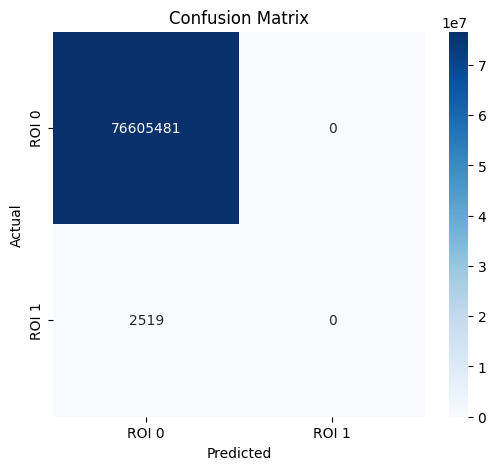

In [15]:
import seaborn as sns
# --- Confusion Matrix Visualization ---
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["ROI 0", "ROI 1"], yticklabels=["ROI 0", "ROI 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

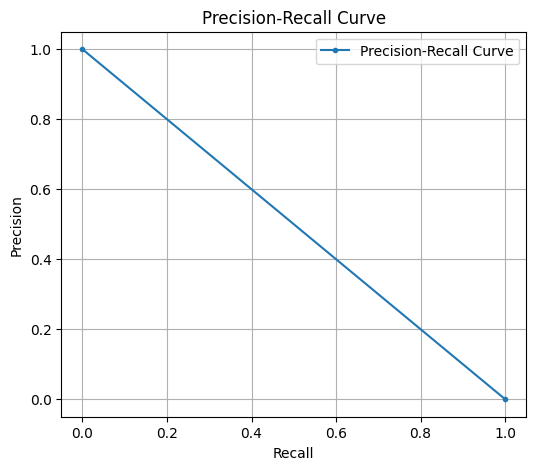

In [17]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, f1_score, precision_score, recall_score
# --- Precision-Recall Curve ---
precisions, recalls, thresholds = precision_recall_curve(y_true_flat, y_pred_flat)

plt.figure(figsize=(6,5))
plt.plot(recalls, precisions, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


In [18]:
# --- IoU Calculation and Visualization ---
def iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union > 0 else 0

iou_score = iou(y_true_flat, y_pred_flat)
print(f"IoU Score: {iou_score:.4f}")

IoU Score: 0.0000


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

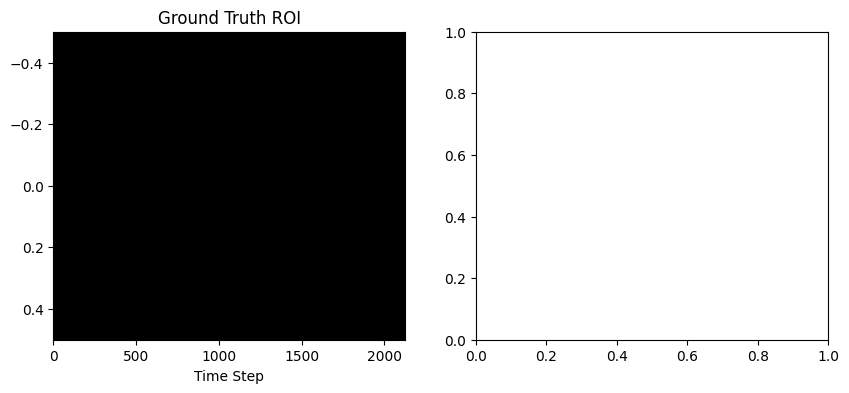

In [19]:
# --- Visualizing an Example ROI ---
sample_idx = np.random.randint(len(y_true))  # Pick a random sample
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(y_true[sample_idx, 0, :].reshape(1, -1), cmap="gray", aspect="auto")
plt.title("Ground Truth ROI")
plt.xlabel("Time Step")

plt.subplot(1, 2, 2)
plt.imshow(y_pred[sample_idx, 0, :].reshape(1, -1), cmap="gray", aspect="auto")
plt.title("Predicted ROI")
plt.xlabel("Time Step")

plt.show()

In [ ]:
# Autoencoder #

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, stride=2, padding=2),  # Output: (16, 1064)
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2), # Output: (32, 532)
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2), # Output: (64, 266)
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1), # Output: (32, 532)
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1), # Output: (16, 1064)
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=5, stride=2, padding=2, output_padding=1), # Output: (1, 2128)
            nn.Tanh()  # Normalize output between -1 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the autoencoder model
autoencoder = Autoencoder().to(device)

In [ ]:
# Input: noise+signal, Output: clean signal
X_autoencoder = noise_data.reshape(num_events * num_channels, 1, num_timesteps)
Y_autoencoder = signal_data.reshape(num_events * num_channels, 1, num_timesteps)

# Define dataset
autoencoder_dataset = ROIDataset(X_autoencoder, Y_autoencoder)

# Train-validation-test split
train_size = int(0.7 * len(autoencoder_dataset))
val_size = int(0.15 * len(autoencoder_dataset))
test_size = len(autoencoder_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(autoencoder_dataset, [train_size, val_size, test_size])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Track loss values
train_losses = []
val_losses = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0

    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        outputs = autoencoder(batch_X)

        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation step
    autoencoder.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_Y in val_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            outputs = autoencoder(batch_X)
            loss = criterion(outputs, batch_Y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot training and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Autoencoder Training and Validation Loss per Epoch")
plt.legend()
plt.show()

# Save the trained model
torch.save(autoencoder.state_dict(), "autoencoder.pth")